# Preparing Model Inputs

In this notebook, we compile all transformed modalities, both simple and structured, to create the final input for the model. To optimize the input data, we perform feature selection by removing highly correlated features (using pairwise correlation and Variance Inflation Factor (VIF)) and filtering out features that are constant or nearly constant within the simple views. All remaining features are quantile normalized.

## Packages

In [2]:
import pickle
from tqdm import tqdm
import numpy as np
import pandas as pd

In [3]:
from sklearn.preprocessing import quantile_transform
import matplotlib.pyplot as plt
from scipy.stats import shapiro
from sklearn.preprocessing import scale
from statsmodels.stats.outliers_influence import variance_inflation_factor 

In [4]:
file_path = './MultiBench/datasets_download'

## MOSI

In [5]:
with open(file_path+'/'+str('MOSI/MOSI_transformed')+'.pkl', "rb") as input_file:
    dataset = pickle.load(input_file)

In [12]:
dataset['M0'].shape, dataset['M1'].shape

((2183, 35), (2183, 74))

In [5]:
with open('data_transformed/MOSI/text_modality_array_sentence1words.pkl', "rb") as input_file:
    [data_text, text_not_empty_ind] = pickle.load(input_file)

In [6]:
# adding a variable for which M0 is constant
text_not_empty_ind[338] = False

In [7]:
dataset_info = {}

In [8]:
dataset['index']

array(['03bSnISJMiM[0]', '03bSnISJMiM[10]', '03bSnISJMiM[11]', ...,
       'zhpQhgha_KU[7]', 'zhpQhgha_KU[8]', 'zhpQhgha_KU[9]'], dtype='<U15')

In [9]:
dataset_info['labels'] = dataset['labels'][:,0]
dataset_info['index'] = dataset['index']
dataset_info['train_val_test'] = dataset['train_val_test']
dataset_info['included'] = text_not_empty_ind

In [10]:
ds_info = pd.DataFrame(dataset_info)

In [11]:
ds_info.to_csv('data_transformed/MOSI/preprocessed_data_info.csv')

In [12]:
dataset_new = {}

In [13]:
text_not_empty_ind = np.array(text_not_empty_ind)

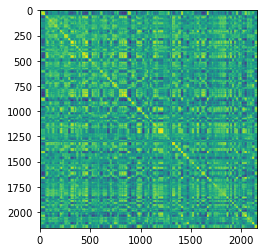

In [14]:
plt.imshow(np.corrcoef(dataset['M0'][text_not_empty_ind, :]))
plt.show()

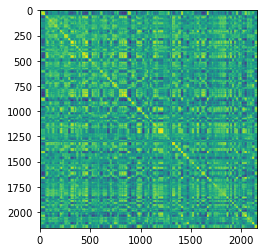

In [218]:
plt.imshow(np.corrcoef(dataset['M0'][text_not_empty_ind, :]).T)
plt.show()

In [15]:
def not_highly_correlated(data):
    list_of_chosen = [1]
    d = data.shape[1]
    for i in range(1, d-1):
        how_many_chosen = len(list_of_chosen)
        if np.all(np.abs(np.corrcoef(data[:,list_of_chosen].T, data[:,i].T)[how_many_chosen:,:how_many_chosen]**2) < 0.95):
            list_of_chosen.append(i)
    return list_of_chosen


In [16]:
def vif_delete(data):

    vif = np.array([variance_inflation_factor(data, i) for i in range(data.shape[1])])
    max_vif = np.max(vif)
    how_many = 0

    while max_vif > 20:
        how_many += 1
        print("delete "+str(np.where(vif >= max_vif)[0])+", because vif = "+str(max_vif))
        data = data[:,vif < max_vif]

        vif = np.array([variance_inflation_factor(data, i) for i in range(data.shape[1])])
        max_vif = np.max(vif)
    print("deteted "+str(how_many))
    return data

In [17]:
df0 = dataset['M0'][text_not_empty_ind, :]

In [18]:
chosen = not_highly_correlated(df0)
print('deleted: ',df0.shape[1] - len(chosen))
df0 = df0[:,chosen]

deleted:  2


In [19]:
df0 = vif_delete(df0)

delete [8], because vif = 145.69212067337932
delete [23], because vif = 70.73634808221513
delete [25], because vif = 60.02864523580226
delete [7], because vif = 51.00286544502783
delete [22], because vif = 47.87625679092262
delete [15], because vif = 40.85067327374027
delete [5], because vif = 38.824672763187316
delete [12], because vif = 36.95928502312621
delete [13], because vif = 33.14049436459242
delete [15], because vif = 25.43816565086401
delete [6], because vif = 22.456680040252486
delete [9], because vif = 21.599456831794114
deteted 12


In [20]:
dataset_new['M0'] = quantile_transform(df0, output_distribution='normal')

In [21]:
df1 = np.clip(dataset['M1'], a_min=np.min(dataset['M1'][dataset['M1'] > -np.inf]), a_max=None)[text_not_empty_ind,:]

In [22]:
df1 = df1[:,np.where(np.var(df1, axis=0) != 0)[0]]

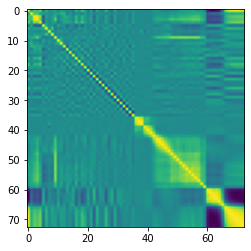

In [23]:
plt.imshow(np.corrcoef(df1.T))
plt.show()

In [24]:
chosen = not_highly_correlated(df1)

In [25]:
print('deleted: ', df1.shape[1] - len(chosen))
df1 = df1[:,chosen]

deleted:  3


In [26]:
df1 = vif_delete(df1)

delete [60], because vif = 4241.449283287832
delete [62], because vif = 1775.1753817753142
delete [61], because vif = 1236.0472055537934
delete [62], because vif = 1033.7851950083264
delete [8], because vif = 548.4299963836448
delete [60], because vif = 492.9716195310737
delete [61], because vif = 422.9644663359635
delete [59], because vif = 256.97921001802587
delete [5], because vif = 198.18978546792312
delete [6], because vif = 138.9963636556072
delete [57], because vif = 121.35522646022888
delete [2], because vif = 92.92153260630873
delete [0], because vif = 66.09766142835902
delete [5], because vif = 49.10743600181341
delete [37], because vif = 41.931174080270324
delete [52], because vif = 32.08686887882696
delete [52], because vif = 30.063078004837955
delete [30], because vif = 24.3128759047584
delete [5], because vif = 22.71023040899145
delete [4], because vif = 20.707641459986192
deteted 20


In [232]:
df1.shape

(2158, 50)

In [233]:
dataset_new['M1'] = quantile_transform(df1, output_distribution='normal')

In [234]:
dataset_new['M2'] = [data_text[n] for n in range(len(data_text)) if text_not_empty_ind[n]]

In [235]:
dataset_new['labels'] = dataset['labels'][text_not_empty_ind,0]

In [236]:
dataset_new['M0'].shape, dataset_new['M1'].shape, len(dataset_new['M2']), len(dataset_new['labels'] )

((2158, 21), (2158, 50), 2158, 2158)

In [237]:
# with open('data_transformed/MOSI/preprocessed_data_sentence1words.pkl', 'wb') as f:  
#     pickle.dump(dataset_new, f, protocol=5)

## MOSEI

In [6]:
with open(file_path+'/'+str('MOSEI/MOSEI_transformed')+'.pkl', "rb") as input_file:
    dataset = pickle.load(input_file)


In [4]:
with open('data_transformed/MOSEI/text_modality_array_sentence1words.pkl', "rb") as input_file:
    [data_text, text_not_empty_ind] = pickle.load(input_file)

In [7]:
dataset_info = {}
dataset_info['labels'] = dataset['labels'][:,0]
dataset_info['index'] = dataset['index']
dataset_info['train_val_test'] = dataset['train_val_test']
dataset_info['included'] = text_not_empty_ind
ds_info = pd.DataFrame(dataset_info)
# ds_info.to_csv('data_transformed/MOSEI/preprocessed_data_info.csv')

In [8]:
df0 = dataset['M0'][text_not_empty_ind, :]

In [12]:
chosen = not_highly_correlated(df0)
print('deleted: ',df0.shape[1] - len(chosen))
df0 = df0[:,chosen]

deleted:  615


In [14]:
df0 = vif_delete(df0)

delete [20], because vif = 3688.6402942348404
delete [8], because vif = 2551.8328988671565
delete [19], because vif = 986.462810689623
delete [12], because vif = 902.1103618306648
delete [1], because vif = 485.54256265664594
delete [16], because vif = 314.3208600127853
delete [9], because vif = 190.65815910915077
delete [5], because vif = 95.34324428845571
delete [3], because vif = 53.32398033014339
delete [11], because vif = 43.974309237887056
delete [4], because vif = 29.49952812044412
delete [3], because vif = 22.885029021862877
deteted 12


In [15]:
df1 = dataset['M1'][text_not_empty_ind, :]

In [16]:
df1.shape

(22761, 74)

In [17]:
chosen = not_highly_correlated(df1)
print('deleted: ', df1.shape[1] - len(chosen))
df1 = df1[:,chosen]

/home/mlazecka/miniconda2/envs/data_multibench/lib/python3.8/site-packages/numpy/lib/function_base.py:2474: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]


deleted:  4


In [18]:
df1 = vif_delete(df1)

delete [63], because vif = 1698.8568518274126
delete [60], because vif = 1239.0106838198503
delete [63], because vif = 1144.6555256078211
delete [61], because vif = 869.4953874383538
delete [63], because vif = 565.9679513252197
delete [61], because vif = 492.5229062001257
delete [7], because vif = 330.49874480566154
delete [5], because vif = 202.90400838143597
delete [60], because vif = 197.7068276617999
delete [5], because vif = 112.59291253546644
delete [57], because vif = 88.64685586197317
delete [2], because vif = 74.13964868343379
delete [5], because vif = 54.090497667189844
delete [0], because vif = 47.787814689127124
delete [54], because vif = 36.82354565772726
delete [4], because vif = 23.483026144473417
deteted 16


In [20]:
def create_data(n_words):
    with open('data_transformed/MOSEI/text_modality_array_sentence'+str(n_words)+'words.pkl', "rb") as input_file:
        [data_text, text_not_empty_ind] = pickle.load(input_file)
    dataset_new = {}
    text_not_empty_ind = np.array(text_not_empty_ind)
    dataset_new['M0'] = quantile_transform(dataset['M0'], output_distribution='normal')[text_not_empty_ind, :]
    dataset_new['M1'] = quantile_transform(np.clip(dataset['M1'], a_min=np.min(dataset['M1'][dataset['M1'] > -np.inf]), a_max=None), output_distribution='normal')[text_not_empty_ind, :]
    dataset_new['M2'] = [data_text[n] for n in range(len(data_text)) if text_not_empty_ind[n]]
    dataset_new['labels'] = dataset['labels'][text_not_empty_ind,0]
    print(dataset_new['M0'].shape, dataset_new['M1'].shape, len(dataset_new['M2']), len(dataset_new['labels'] ))
    return dataset_new
dataset_new = create_data(1)

(22761, 713) (22761, 74) 22761 22761


In [21]:
dataset_new['M0'] = quantile_transform(df0, output_distribution='normal')
dataset_new['M1'] = quantile_transform(df1, output_distribution='normal')
dataset_new['M2'] = [data_text[n] for n in range(len(data_text)) if text_not_empty_ind[n]]
dataset_new['labels'] = dataset['labels'][text_not_empty_ind, 0]

In [22]:
print(dataset_new['M0'].shape, dataset_new['M1'].shape, len(dataset_new['M2']), len(dataset_new['labels'] ))

(22761, 86) (22761, 54) 22761 22761


In [205]:
dataset_new.keys()

dict_keys(['M0', 'M1', 'M2', 'labels'])

In [23]:
with open('data_transformed/MOSEI/preprocessed_data_sentence1words.pkl', 'wb') as f:  
    pickle.dump(dataset_new, f, protocol=5)